In [1]:
import os
import csv
import matplotlib.pyplot as plt  # plotting
import numpy as np  # numerics
from skimage import io
from natsort import natsorted
#import skimage.io
import skimage.color
import skimage.morphology
import skimage.measure as sm

from skimage.io import imread
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from skimage import (io, filters,  morphology, measure, segmentation, feature, util, exposure)
from scipy.ndimage import gaussian_filter 
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom


In [2]:
#define two folder paths - for September 2023 and October 2023 
folder_path_september = './HoloMonitor Beta TIFF/September 2023/MDCK Edna_06.09.23-B1-1_100ul'
folder_path_october = './HoloMonitor Beta TIFF/October 2023/MDCK 17.10.23/B2-1'


In [3]:
list_files_september = [os.path.join(folder_path_september, f) for f in os.listdir(folder_path_september)]
list_files_september = natsorted(list_files_september)
image_list_september = []

#open all images in the stack
for filename in list_files_september:
    image_list_september.append(io.imread(filename))

list_files_october = [os.path.join(folder_path_october, f) for f in os.listdir(folder_path_october)]
list_files_october = natsorted(list_files_october)
image_list_october = []

#open all images in the stack
for filename in list_files_october:
    image_list_october.append(io.imread(filename))

### Plotting sum of all pixel values for each image in the stack to see if the pixel valus is conserved:

In [6]:
#find the sum of all pixels in each image stack and plot the values 
sum_of_pixels_september = []
for image in image_list_september:
    sum_of_pixels_september.append(np.sum(image))

sum_of_pixels_october = []
for image in image_list_october:
    sum_of_pixels_october.append(np.sum(image))

Text(0.5, 1.0, 'October 2023')

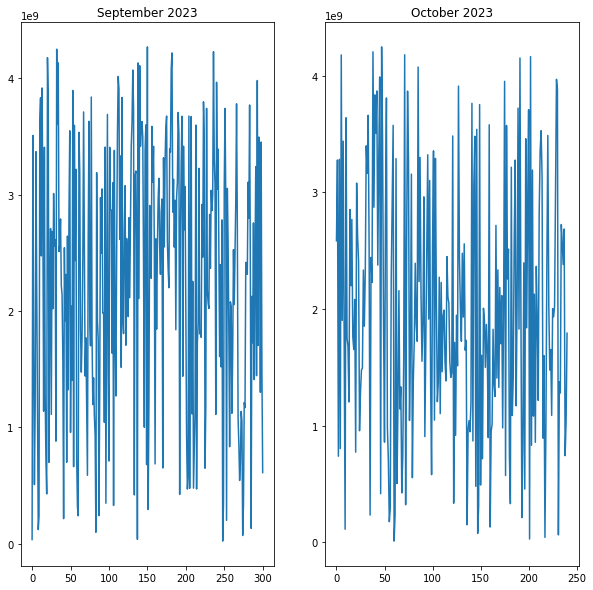

In [20]:
#plot subplots of the sum of pixels in each image stack
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].plot(sum_of_pixels_september)
ax[0].set_title('September 2023')
ax[1].plot(sum_of_pixels_october)
ax[1].set_title('October 2023')

In [21]:
#want to plot deviation from mean for each image stack
mean_september = np.mean(sum_of_pixels_september)
mean_october = np.mean(sum_of_pixels_october)
deviation_september = []
deviation_october = []
for i in range(len(sum_of_pixels_september)):
    deviation_september.append(sum_of_pixels_september[i] - mean_september)
    
for i in range(len(sum_of_pixels_october)):
    deviation_october.append(sum_of_pixels_october[i] - mean_october)

In [29]:
print(sum_of_pixels_september)
print(deviation_september)

[34219805, 3508411856, 1692951263, 506562418, 1195741328, 3368859571, 2204354534, 1230706178, 119819309, 237262655, 3632833522, 3831753321, 2472285772, 3916569489, 2852829784, 1137698907, 3407137407, 1276815834, 722492276, 426127843, 4177458670, 3813325136, 697972163, 2167852310, 2708280134, 1109681025, 2682840218, 2019026180, 3008786893, 2557374103, 2610293231, 880035847, 4249963510, 3604960330, 4132215876, 2510169885, 2567989233, 2790399601, 2216795904, 2137461289, 1585626777, 213793415, 2543172026, 1915612208, 2313453347, 698534993, 2643301540, 1322226705, 2853507493, 3548269728, 955254095, 2040803075, 1404400178, 3895123610, 660806623, 3596124610, 2432760971, 3216832762, 742312375, 313524064, 238287315, 3535857913, 3192190574, 1836061713, 1473587113, 1772138873, 2457115576, 3710452406, 2609107175, 1440058893, 1768338357, 1209484404, 586341901, 2608943724, 3629894470, 1952622006, 1699566699, 3838668677, 1768931257, 1194165149, 1424037513, 1097565015, 929002830, 96803160, 3188005586,

Text(0, 0.5, 'Deviation from mean')

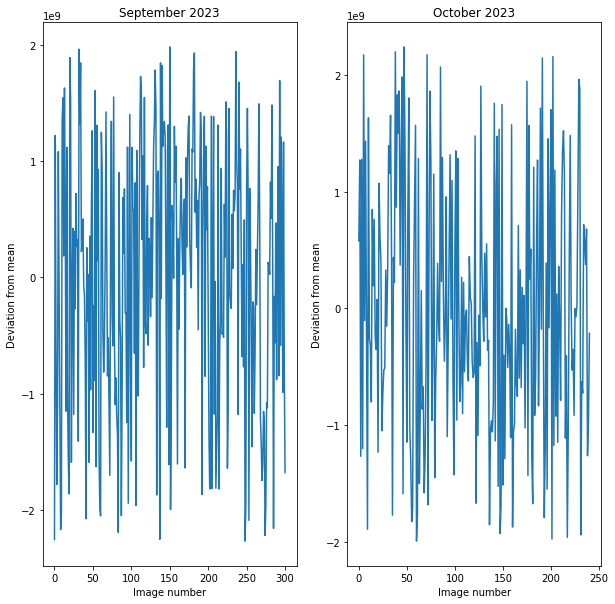

In [27]:
#visualise the deviation to see how big they are 
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].plot(deviation_september)
ax[0].set_title('September 2023')
ax[1].plot(deviation_october)
ax[1].set_title('October 2023')
#set labels for axis 
ax[0].set_xlabel('Image number')
ax[0].set_ylabel('Deviation from mean')
ax[1].set_xlabel('Image number')
ax[1].set_ylabel('Deviation from mean')


Text(0, 0.5, 'Frequency')

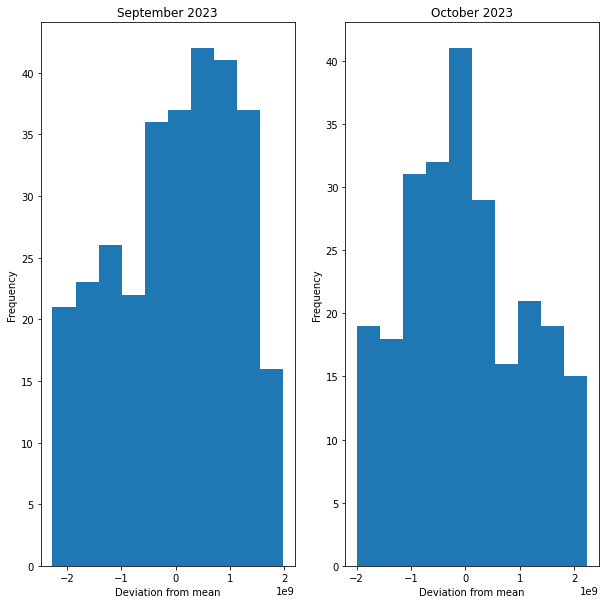

In [25]:
#visualise as a histogram - ps. not normalised histograms, this was just for a quick check 
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].hist(deviation_september)
ax[0].set_title('September 2023')
ax[1].hist(deviation_october)
ax[1].set_title('October 2023')
#label the axes
ax[0].set_xlabel('Deviation from mean')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Deviation from mean')
ax[1].set_ylabel('Frequency')


### Median, mean and standard deviation analysis:

In [30]:
#import height values from csv file for each dataset 
csv_file_path_september = 'September_2023_MDCK_Edna_06.09.23-B1-1_100ul_minmaxvalues_rawHM.csv'
csv_file_path_october = 'MDCK_17.10.23_B2-1_minmaxvalues_rawHM.csv' 

##### Working with september dataset:

In [31]:
min_values_september = []
max_values_september = []

# Read the CSV file
with open(csv_file_path_september, 'r') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file)
    
    # Skip the header row if it exists
    header = next(csv_reader, None)
    
    # Iterate through the rows and extract data
    for row in csv_reader:
        min_values_september.append(float(row[0]))
        max_values_september.append(float(row[1]))
        
min_values_september = np.array(min_values_september)
max_values_september = np.array(max_values_september)

In [40]:
median_of_minima_september = np.median(min_values_september)

#mark images whose minima are different from the median
#if the difference is more than 0, add the image to "avvik_september" list
avvik_september_index = [] #indices of images whose minima are different from the median
for i in range(len(min_values_september)):
    if min_values_september[i] - median_of_minima_september != 0:
        avvik_september_index.append(i)
        
#save the avvik values
avvik_september = []
for i in avvik_september_index:
    avvik_september.append(min_values_september[i])

[-1.533557, -1.432298, -2.022336, -1.436398, -1.083604, -1.259248]


In [42]:
#compute the mean intensity for each image 
mean_intensity_september = []
for image in image_list_september:
    mean_intensity_september.append(np.mean(image))

In [43]:
#compute the standard deviation for each image
std_intensity_september = []
for image in image_list_september:
    std_intensity_september.append(np.std(image))

In [44]:
#find image the mean intensity is more than one standard deviation away from the mean
avvik_september_index2 = []
for i in range(len(mean_intensity_september)):
    if mean_intensity_september[i] - np.median(np.mean(mean_intensity_september)) > np.std(mean_intensity_september):
        avvik_september_index2.append(i)

In [46]:
print(avvik_september_index2)
print(avvik_september_index)

[52, 55, 171, 220, 274, 294]
[81, 136, 195, 217, 250, 253]


I see that the images that have min value deviating from the median value are not the same images that have mean intensity deviating from the mediam mean value of the entire stack.

What happens if I compare the mean intensity in each image with the mean intensity of the entire stack? And not the median value of the mean for the entire stack? Let's see:

In [50]:
avvik_september_index3 = []
for i in range(len(mean_intensity_september)):
    if mean_intensity_september[i] - np.mean(mean_intensity_september) > np.std(mean_intensity_september):
        avvik_september_index3.append(i)

In [51]:
print(avvik_september_index3)

[52, 55, 171, 220, 274, 294]


This did not really pring me anywhere. Maybe I can investigate the intensity histograms a bit better? And apply it to other datasets, and finally do my machine learning stuff?